<a href="https://colab.research.google.com/github/Ugo5738/MobileNets-Facial-Recognition-/blob/main/Face_recognition_with_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os 
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Vanilla MobileNet

In [ ]:
def prepare_image(img_file):
    img_path = '/content/drive/MyDrive/Recognition/train/jenny/'
    img = image.load_img(img_path + img_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
preprocessed_image = prepare_image('IMG_0980.JPG')

In [ ]:
preprocessed_image

array([[[[ 0.39607847,  0.3411765 ,  0.19215691],
         [ 0.43529415,  0.3803922 ,  0.2313726 ],
         [ 0.43529415,  0.39607847,  0.24705887],
         ...,
         [-0.62352943, -0.6       , -0.654902  ],
         [-0.6784314 , -0.67058825, -0.7176471 ],
         [-0.5686275 , -0.5764706 , -0.6156863 ]],

        [[ 0.3411765 ,  0.30196083,  0.14509809],
         [ 0.3176471 ,  0.26274514,  0.12156868],
         [ 0.41960788,  0.36470592,  0.22352946],
         ...,
         [-0.62352943, -0.6156863 , -0.6627451 ],
         [-0.5686275 , -0.56078434, -0.62352943],
         [-0.6156863 , -0.60784316, -0.67058825]],

        [[ 0.41960788,  0.36470592,  0.21568632],
         [ 0.38823533,  0.33333337,  0.19215691],
         [ 0.3803922 ,  0.32549024,  0.18431377],
         ...,
         [-0.62352943, -0.6156863 , -0.6627451 ],
         [-0.5764706 , -0.5686275 , -0.6313726 ],
         [-0.5921569 , -0.58431375, -0.64705884]],

        ...,

        [[ 0.99215686,  0.99215686,  0

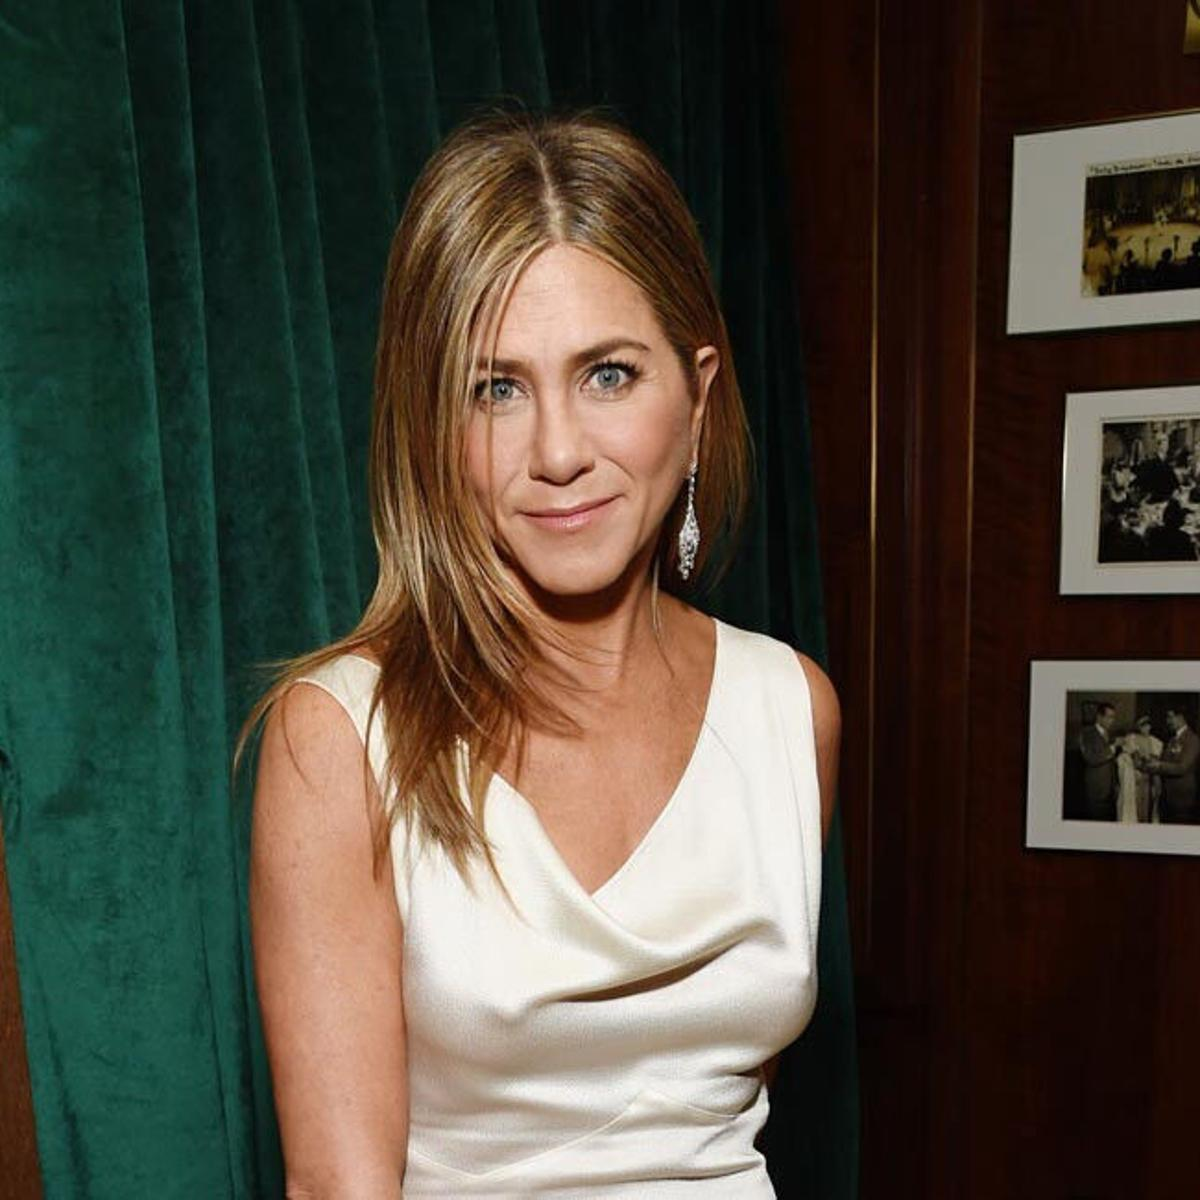

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Recognition/train/jenny/19.jpg', width=224, height=224)

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

In [ ]:
# vanilla mobilenet prediction
preprocessed_image = prepare_image('16.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

49152/35363 [=========================================] - 0s 0us/step


[[('n03594734', 'jean', 0.1900534),
  ('n03710637', 'maillot', 0.11476906),
  ('n03770439', 'miniskirt', 0.08531052),
  ('n02992529', 'cellular_telephone', 0.06393736),
  ('n06359193', 'web_site', 0.06066575)]]

# Custom MobileNet

In [ ]:
# Create working directories
train_dir = '/content/drive/MyDrive/Recognition/train'
validation_dir = '/content/drive/MyDrive/Recognition/validation'

## Use Data Augmentation with the Image Generator API

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                  preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                  rotation_range=40,
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest' 
)

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=5,
                                                    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
                                                              validation_dir,
                                                              target_size=(224, 224),
                                                              batch_size=4,
                                                              class_mode='categorical'
)

Found 132 images belonging to 3 classes.
Found 37 images belonging to 3 classes.


## Finetuning MobileNet

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3))
x = mobile.layers[-6].output
output = Dense(units=3, activation='softmax')(x)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]: # select the number of layers you want to finetune or train from
    layer.trainable = False  # set to true to finetune

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train Image Classifier model

In [ ]:
history = model.fit(
                    train_generator,
                    # steps_per_epoch=total_training_images/32,
                    epochs=100,
                    verbose=2,
                    validation_data=validation_generator,
                    # validation_steps=total_validation_images/32,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')]
)

Epoch 1/100
27/27 - 161s - loss: 0.6720 - accuracy: 0.7197 - val_loss: 2.4845 - val_accuracy: 0.2703
Epoch 2/100
27/27 - 28s - loss: 0.1622 - accuracy: 0.9697 - val_loss: 0.5172 - val_accuracy: 0.8378
Epoch 3/100
27/27 - 28s - loss: 0.0586 - accuracy: 0.9924 - val_loss: 0.0947 - val_accuracy: 0.9730
Epoch 4/100
27/27 - 33s - loss: 0.0508 - accuracy: 0.9924 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 5/100
27/27 - 28s - loss: 0.0585 - accuracy: 0.9924 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 6/100
27/27 - 28s - loss: 0.0362 - accuracy: 0.9924 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 7/100
27/27 - 28s - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 8/100
27/27 - 28s - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 9/100
27/27 - 28s - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 10/100
27/27 - 28s - loss: 0.0205 - accuracy: 0.9924 - val_loss: 9.1321e-04 - val_accuracy: 1

Use a Training and Validation Accuracy Graph to check for Overfitting

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

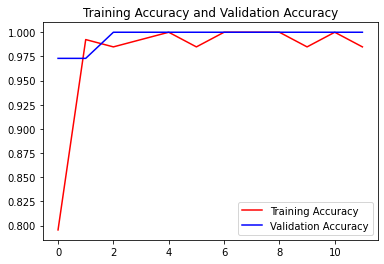

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

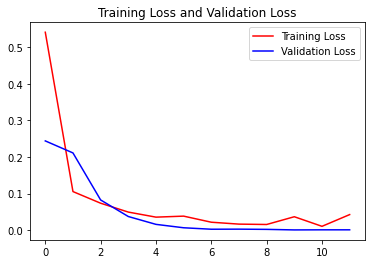

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Test Classifier

In [ ]:
def prepare_image(img_file):
    img_path = '/content/drive/MyDrive/Test/'
    img = image.load_img(img_path + img_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

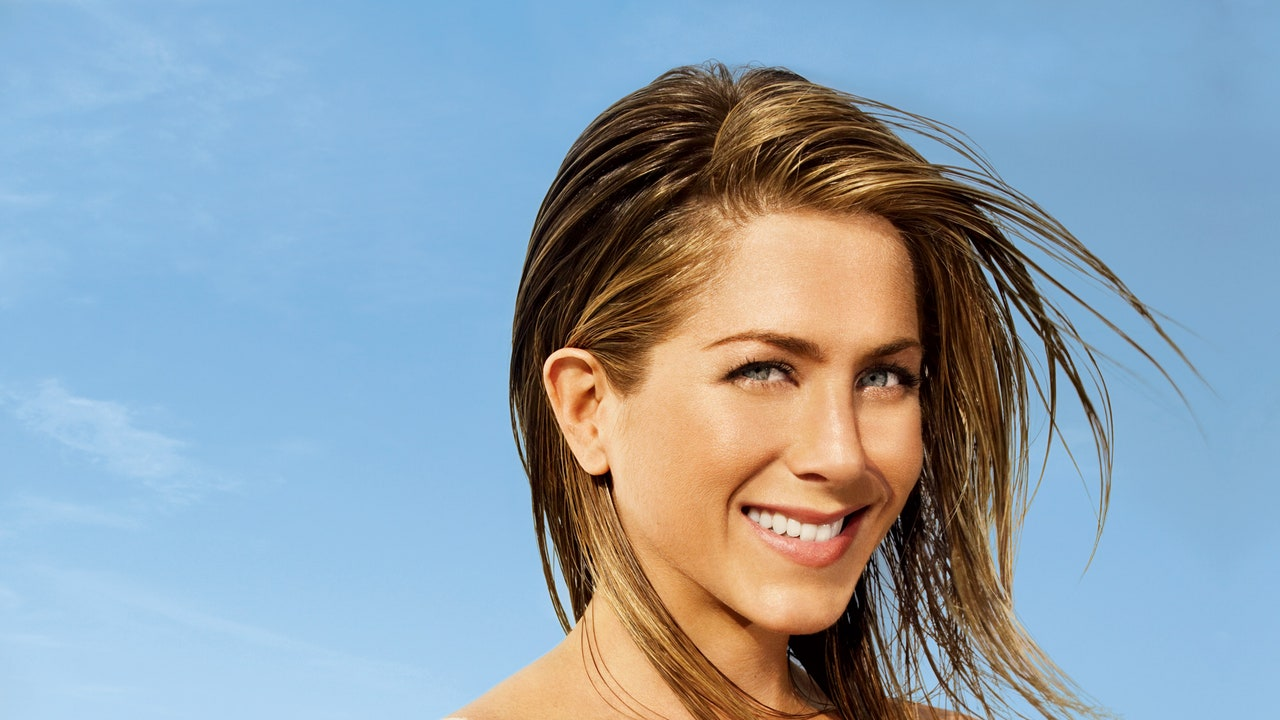

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Test/21.jpg', width=400, height=250)

In [ ]:
preprocessed_image = prepare_image('21.jpg')
predictions = model.predict(preprocessed_image) # check dtype
prediction = predictions.tolist()[0]
print(prediction)

[6.899069558130577e-05, 1.0827856385731138e-05, 0.999920129776001]


In [ ]:
max_value = max(prediction)
max_index = prediction.index(max_value)
max_index

2

In [ ]:
print(f'This image is an image of {names[max_index]}')

This image is an image of Jennifer


## Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix with normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]))
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices  # print all classification labels in the console

In [ ]:
cm_plot_labels = ['blessing', 'daniel', 'jenny']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, titles='Confusion Matrix')

In [ ]:
# 3 -   We don't need all nodes, 20% of nodes will be dropped out [probability of each "bad" node being dropped is 20%
#       Bad here means the nodes which are not contributing much value to the final output


## Save Model

In [ ]:
tf.lite.TFLiteConverter.from_saved_model() (recommended)
tf.lite.TFLiteConverter.from_keras_model()

In [ ]:
# Export saved model
FACIAL_RECOGNITION_SAVED_MODEL_DIR = "fc_saved_model/1"

In [ ]:
tf.saved_model.save(model, FACIAL_RECOGNITION_SAVED_MODEL_DIR)

In [ ]:
# Define the generator
def generator():
    data = tfds.load()
    for _ in range(num_calibration_steps):
        image, = data.take(1)
        yield [image]

In [ ]:
# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(FACIAL_RECOGNITION_SAVED_MODEL_DIR)
# optimization mode
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = tf.lite.RepresentativeDataset(generator)
tflite_model = converter.convert()

In [ ]:
# Save the model
tflite_model_file = pathlib.Path('/content/fc_model.tflite')
tflite_model_file.write_bytes(tflite_model)

# TFLite Interpreter

In [ ]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensor()

In [ ]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])